In [1]:
import pickle

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
with open('../data/interim/02_cleaned.pkl', 'rb') as picklefile:
    df_listings = pickle.load(picklefile)

In [3]:
with open('../data/interim/05_nmf_topics.pkl', 'rb') as picklefile:
    df_topics = pickle.load(picklefile)

In [4]:
df_topics = df_topics[['neighborhood', 'city', 'topic']]

In [5]:
df_listings = df_listings.merge(df_topics, how='left', on=['neighborhood', 'city'])

In [6]:
df_listings = df_listings.dropna().reset_index(drop=True)

#### Create dummy variables

In [7]:
cat_columns = ['host_is_superhost', 'host_response_time', 'cancellation_policy', 'room_type']

In [8]:
df_dummies = df_listings[['neighborhood', 'city', 'reviews_per_month', 'topic', 'bathrooms', 'property_type']]

In [9]:
df_dummies.loc[df_dummies['bathrooms'] <= 1, 'bathrooms'] = 0
df_dummies.loc[df_dummies['bathrooms'] > 1, 'bathrooms'] = 1
df_dummies.rename(columns={'bathrooms': 'multiple_bathrooms'}, inplace=True)

/Users/evaward/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/evaward/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [10]:
conventional = ['Apartment', 'House', 'Condominium', 'Loft', 'Townhouse']
professional = ['Bed & Breakfast', 'Hostel', 'Boutique Hotel']

In [11]:
df_dummies.loc[:, 'property_cat'] = df_dummies['property_type'].apply(lambda x: 'conventional' if x in conventional else ('professional' if x in professional else 'quirky'))
df_temp = pd.get_dummies(df_dummies['property_cat'], drop_first=True)
df_dummies = df_dummies.merge(df_temp, left_index=True, right_index=True)
df_dummies.drop(['property_type', 'property_cat'], axis=1, inplace=True)

/Users/evaward/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [12]:
df_dummies.head()

,neighborhood,city,reviews_per_month,topic,multiple_bathrooms,professional,quirky
0,Brentwood,austin,0.17,easy car access,0.0,0.0,0.0
1,Brentwood,austin,0.56,easy car access,0.0,0.0,0.0
2,Brentwood,austin,0.55,easy car access,0.0,0.0,0.0
3,Brentwood,austin,0.02,easy car access,0.0,0.0,0.0
4,Brentwood,austin,4.84,easy car access,0.0,0.0,0.0


In [13]:
for column in cat_columns:
    df_temp = pd.get_dummies(df_listings[column], drop_first=False, prefix=column)
    df_dummies = df_dummies.merge(df_temp, left_index=True, right_index=True)

In [15]:
df_dummies.columns

Index([u'neighborhood', u'city', u'reviews_per_month', u'topic',
       u'multiple_bathrooms', u'professional', u'quirky',
       u'host_is_superhost_f', u'host_is_superhost_t',
       u'host_response_time_a few days or more',
       u'host_response_time_no response', u'host_response_time_within a day',
       u'host_response_time_within a few hours',
       u'host_response_time_within an hour', u'cancellation_policy_flexible',
       u'cancellation_policy_moderate', u'cancellation_policy_no_refunds',
       u'cancellation_policy_strict', u'cancellation_policy_super_strict_30',
       u'cancellation_policy_super_strict_60', u'room_type_Entire home/apt',
       u'room_type_Private room', u'room_type_Shared room'],
      dtype='object')

In [17]:
df_dummies.drop(['host_is_superhost_f', 'host_response_time_within an hour', 'cancellation_policy_flexible', 'room_type_Entire home/apt'], axis=1, inplace=True)

#### Standardize numerical features

In [18]:
numerical_columns = ['price_person', 'review_scores_rating']

In [19]:
scale = StandardScaler()
df_num = pd.DataFrame(scale.fit_transform(df_listings[numerical_columns]))
df_num.columns = numerical_columns

#### Merge dataframes

In [20]:
df_model = df_dummies.merge(df_num, left_index=True, right_index=True)

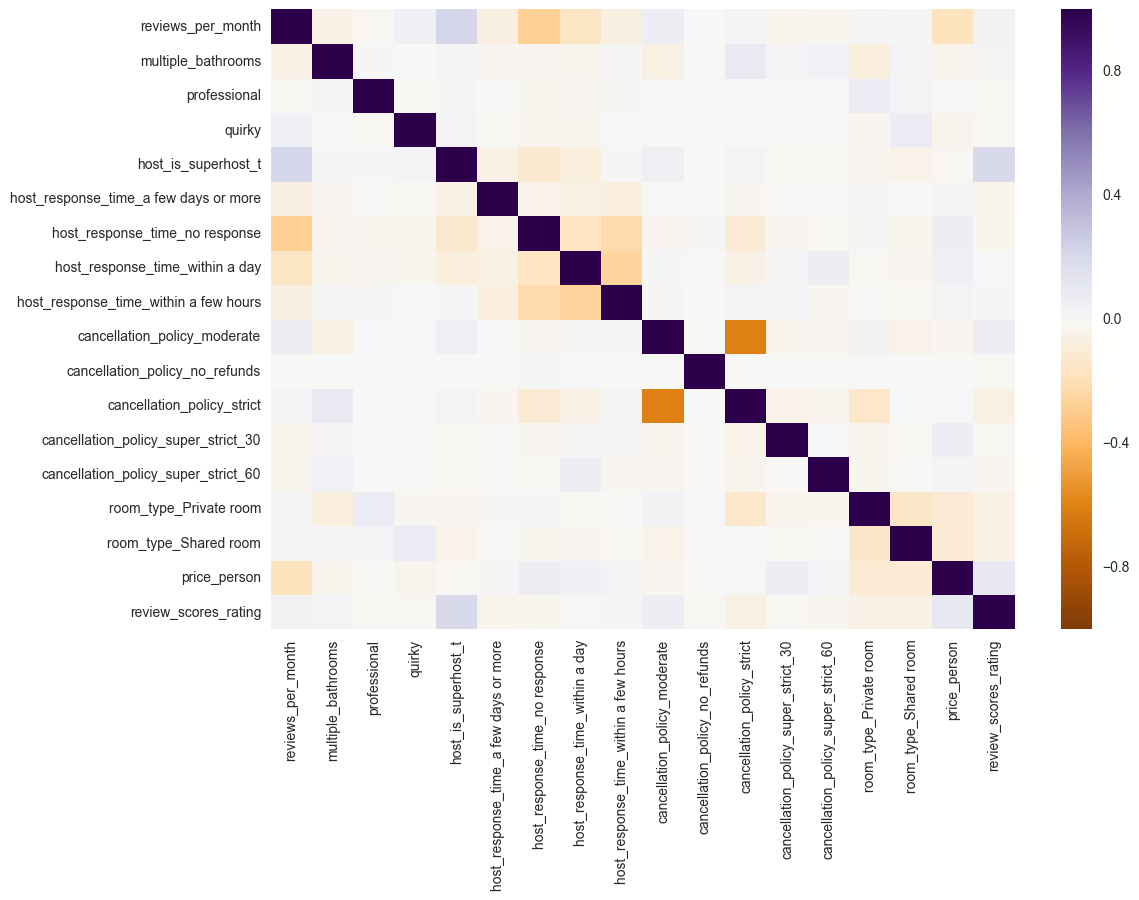

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(df_model.corr(), ax=ax, cmap="PuOr");

In [22]:
X = df_model.drop(['neighborhood', 'city', 'topic'], axis=1)
y = X.pop('reviews_per_month')

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)

In [24]:
lr = LinearRegression()

In [25]:
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.2153105693245283

In [26]:
lr.score(X_test, y_test)

0.21590897770776754

In [27]:
features = X.columns.tolist()
coefficients = lr.coef_.tolist()
zip(features, coefficients)

[('multiple_bathrooms', -0.31035865665186113),
 ('professional', -0.3964760815792891),
 ('quirky', 0.2916475640115369),
 ('host_is_superhost_t', 0.7185029175478547),
 ('host_response_time_a few days or more', -1.4510393700748692),
 ('host_response_time_no response', -1.8242024655368192),
 ('host_response_time_within a day', -1.1631767487631355),
 ('host_response_time_within a few hours', -0.8097326733589267),
 ('cancellation_policy_moderate', 0.20825257626259908),
 ('cancellation_policy_no_refunds', 4.440892098500626e-16),
 ('cancellation_policy_strict', 0.04995094467763539),
 ('cancellation_policy_super_strict_30', -0.8366201736667007),
 ('cancellation_policy_super_strict_60', -0.7030565958976136),
 ('room_type_Private room', 0.014514006646646704),
 ('room_type_Shared room', -0.0692598986143379),
 ('price_person', -0.22978069112075195),
 ('review_scores_rating', 0.007125508261099922)]

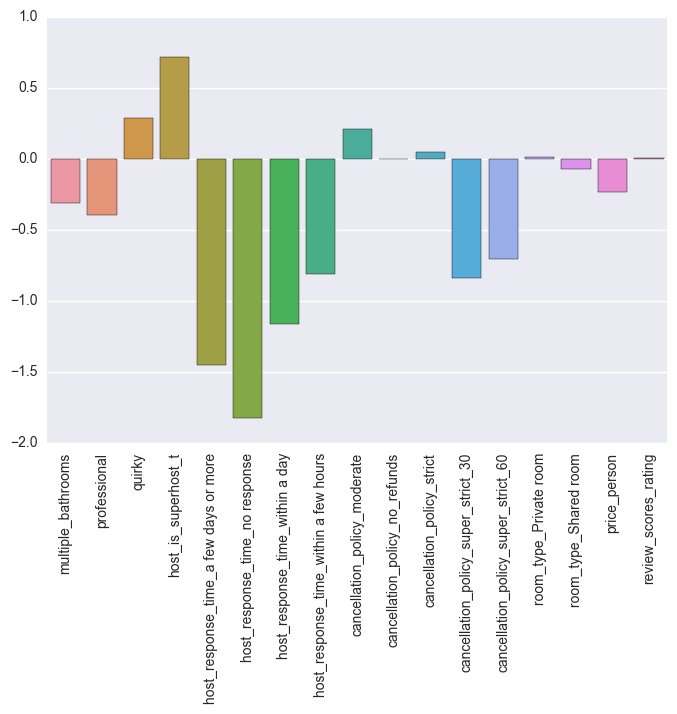

In [28]:
fig = sns.barplot(features, coefficients)
plt.xticks(rotation=90);

### Hyperlocal models

In [29]:
clusters = df_model['topic'].unique().tolist()
clusters.sort()

In [30]:
clusters

['art galleries culture',
 'beach water activities',
 'campus life',
 'diverse residential urban',
 'easy car access',
 'farmers markets',
 'food carts bikes',
 'golf tennis',
 'museums',
 'sports',
 'streetcars jazz',
 'subway',
 'tacos music coffee',
 'trail hike nature',
 'urban nightlife']

In [31]:
#keep features to plot coefficients across clusters
from collections import defaultdict
coef_values = dict.fromkeys(features)
for key in coef_values.keys():
    coef_values[key] = []

In [32]:
from sklearn.metrics import mean_squared_error
import numpy as np

In [33]:
def plot_hyperlocals(cluster):
    X_temp = df_model[df_model['topic'] == cluster].drop(['neighborhood', 'city', 'topic'], axis=1)
    y_temp = X_temp.pop('reviews_per_month')
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=16)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    title = 'Cluster ' + str(cluster) + ', # listings: ' + str(len(y_temp)) + ', RMSE: ' + str(score)
    
    #score = lr.score(X_test, y_test)
    #title = 'Cluster ' + str(cluster) + ', # listings: ' + str(len(y_temp)) + ', r^2: ' + str(score)
    
    features = X_temp.columns.tolist()
    coefficients = lr.coef_.tolist()
    
    for feature, coefficient in zip(features, coefficients):
        coef_values[feature].append(coefficient)

    fig, ax = plt.subplots()
    fig = sns.barplot(features, coefficients)
    #ax.set_ybound(lower=0, upper=0.5)
    fig.axes.set_title(title)
    plt.xticks(rotation=90);

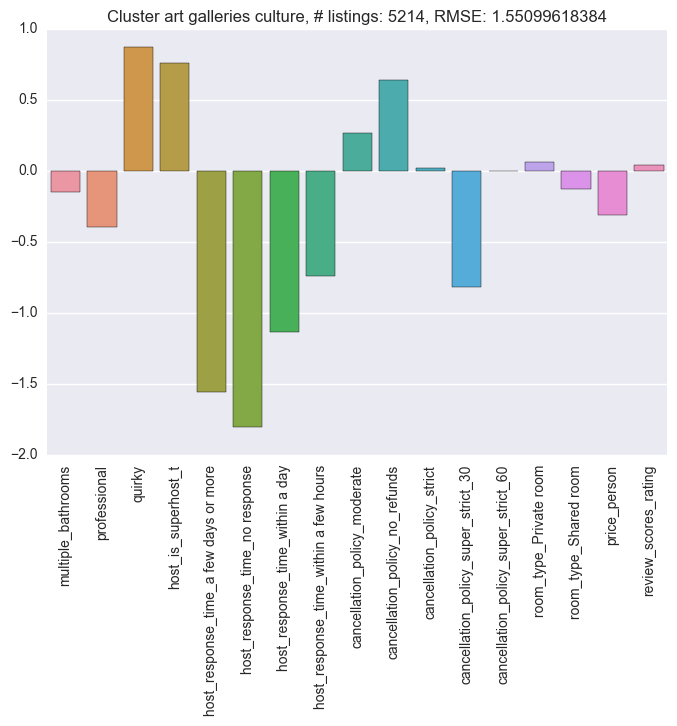

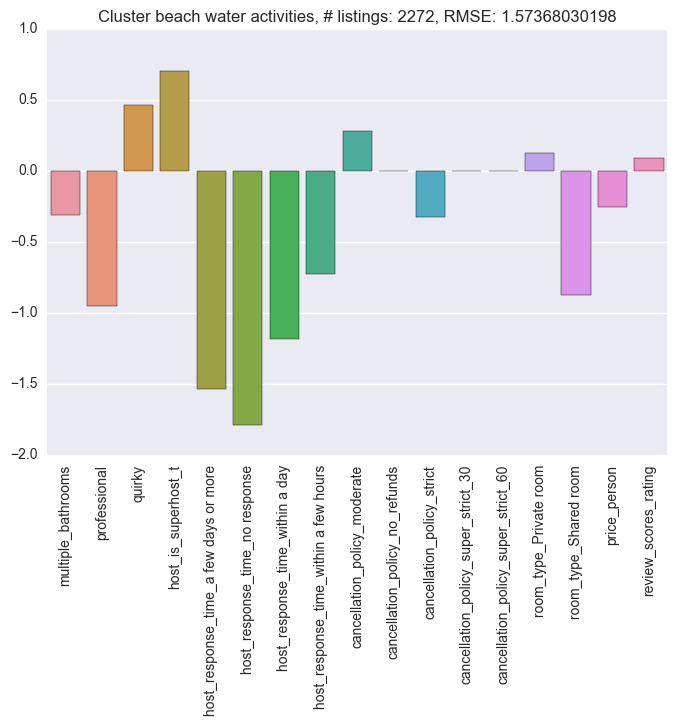

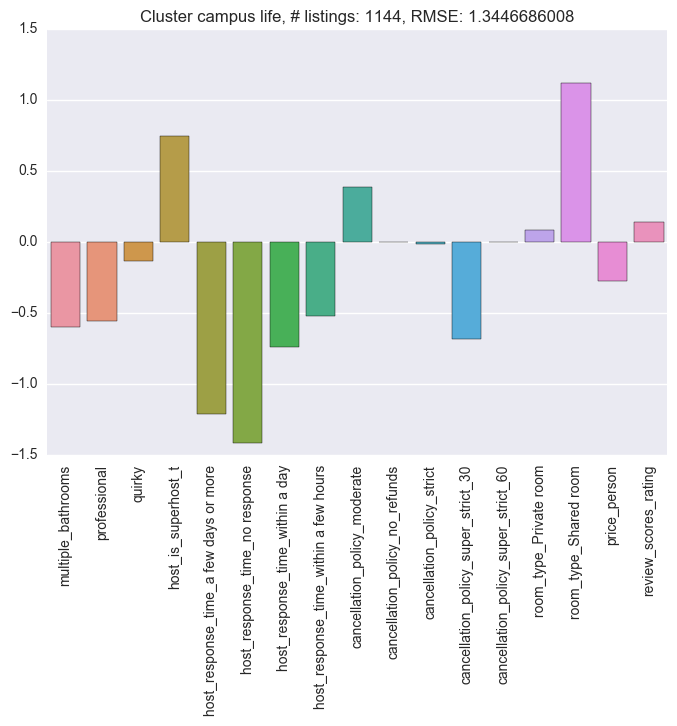

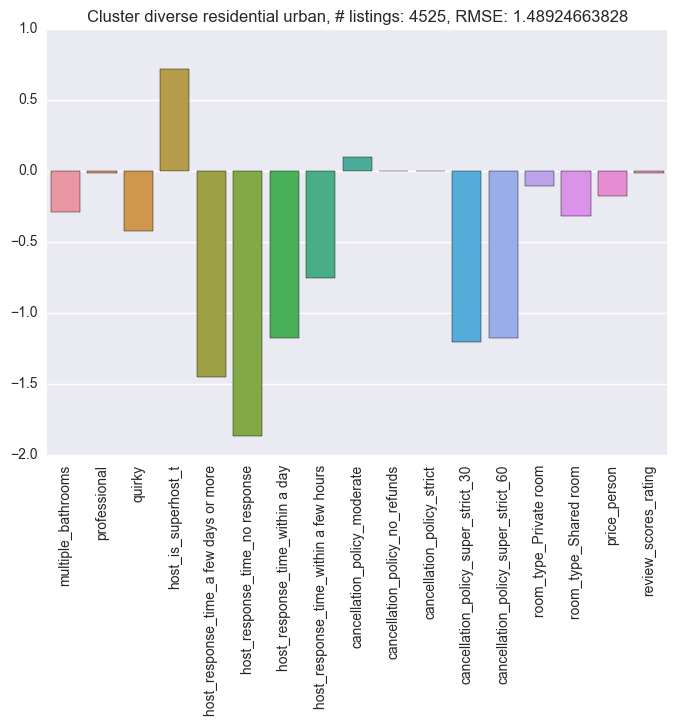

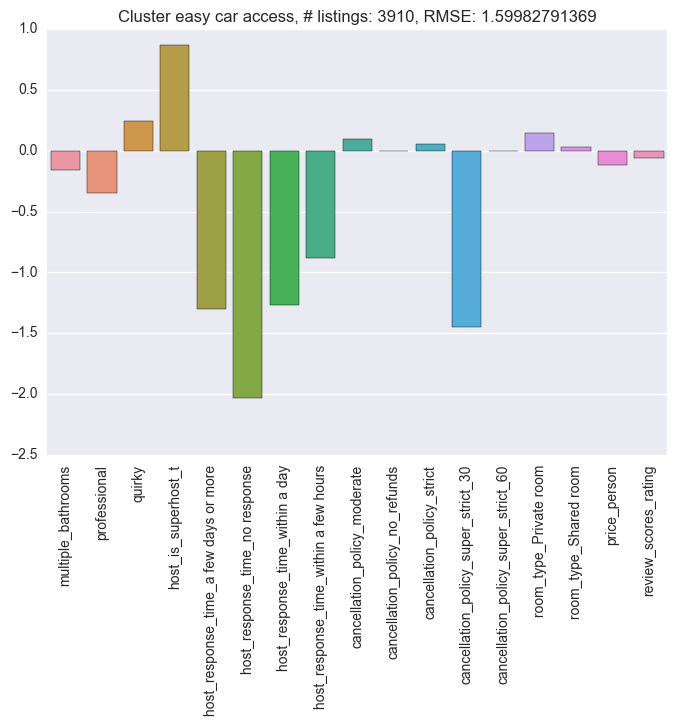

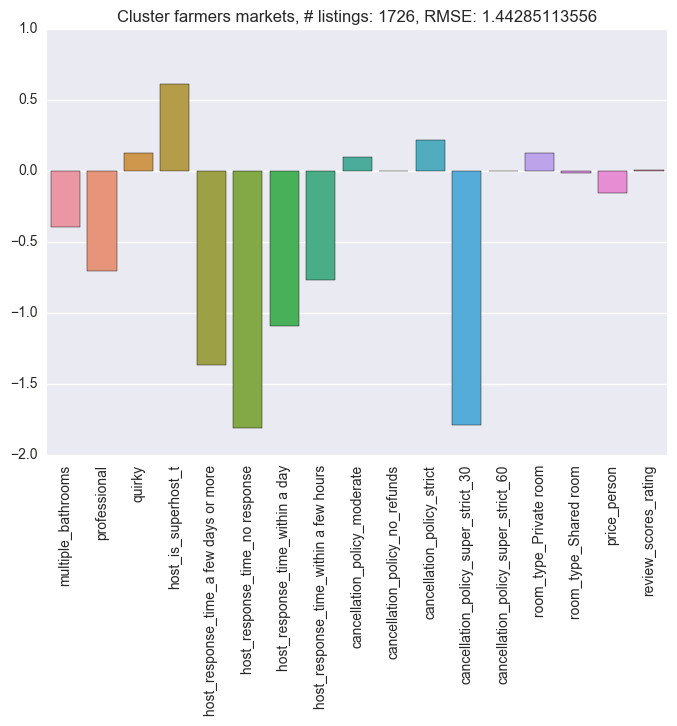

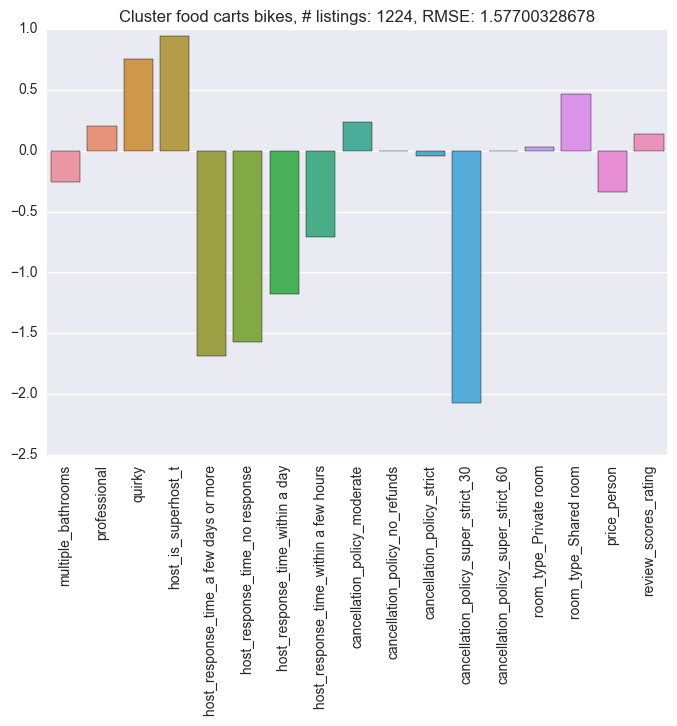

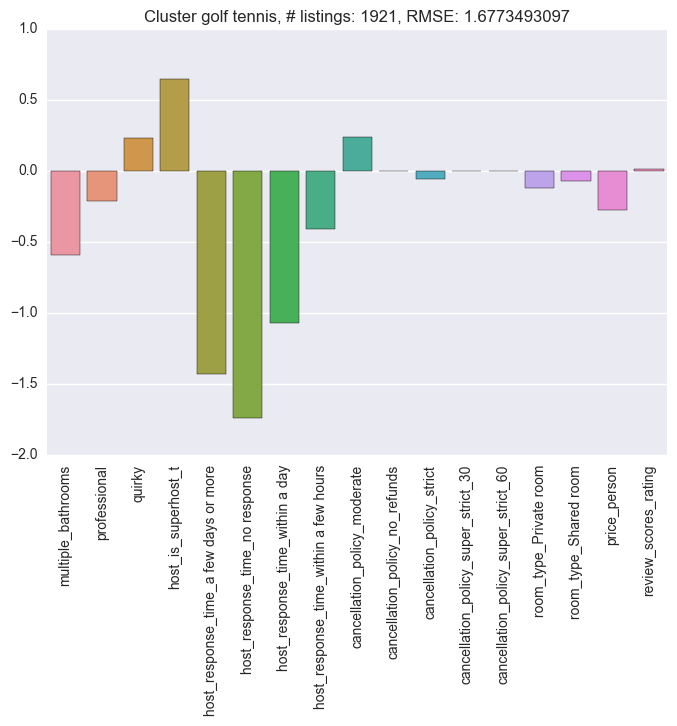

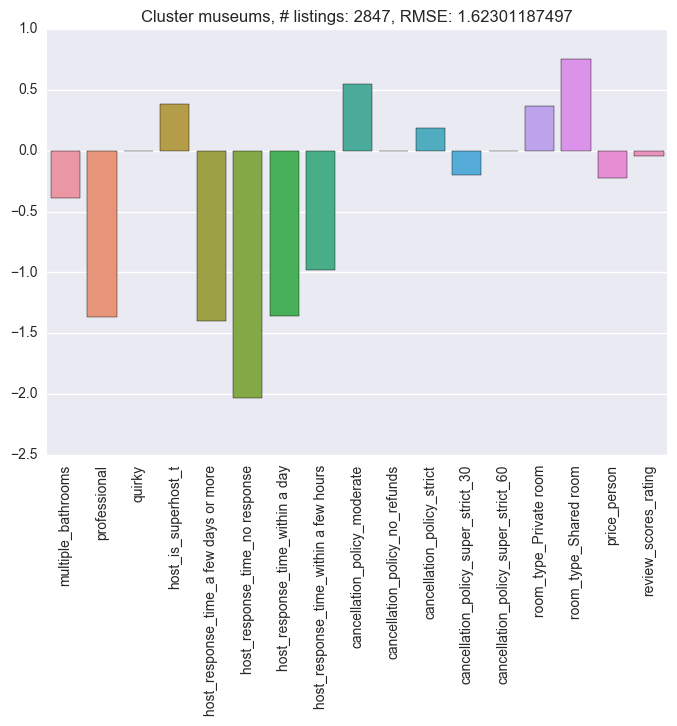

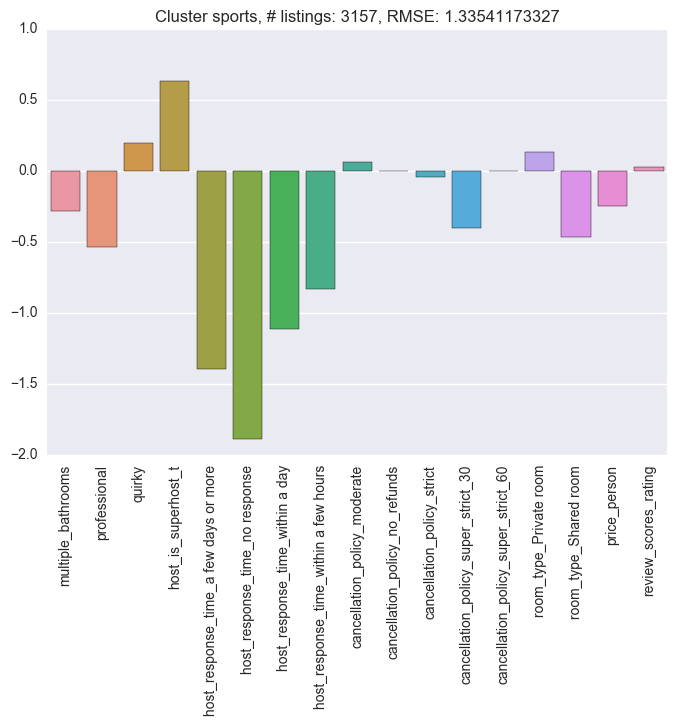

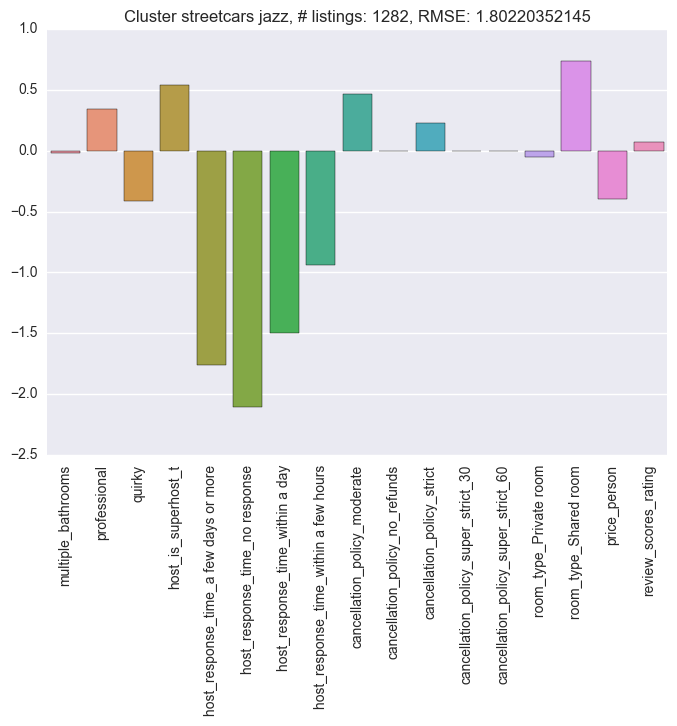

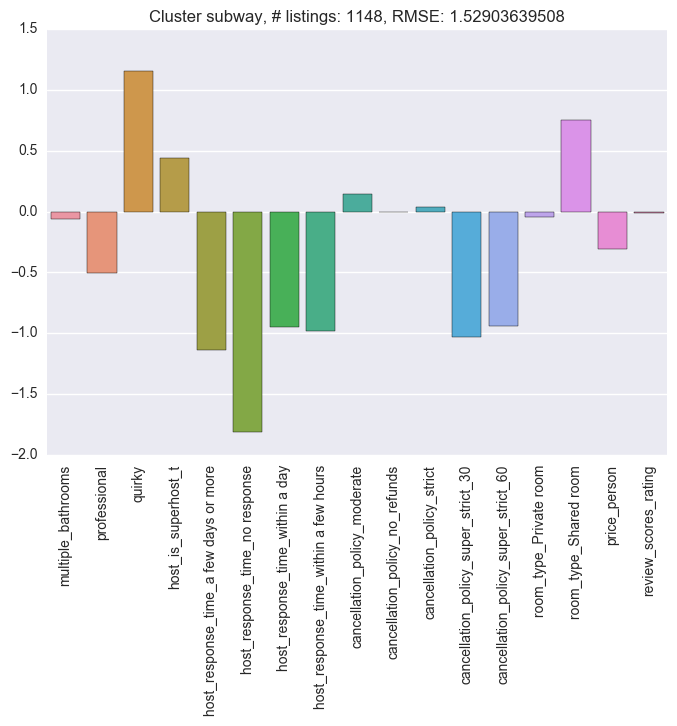

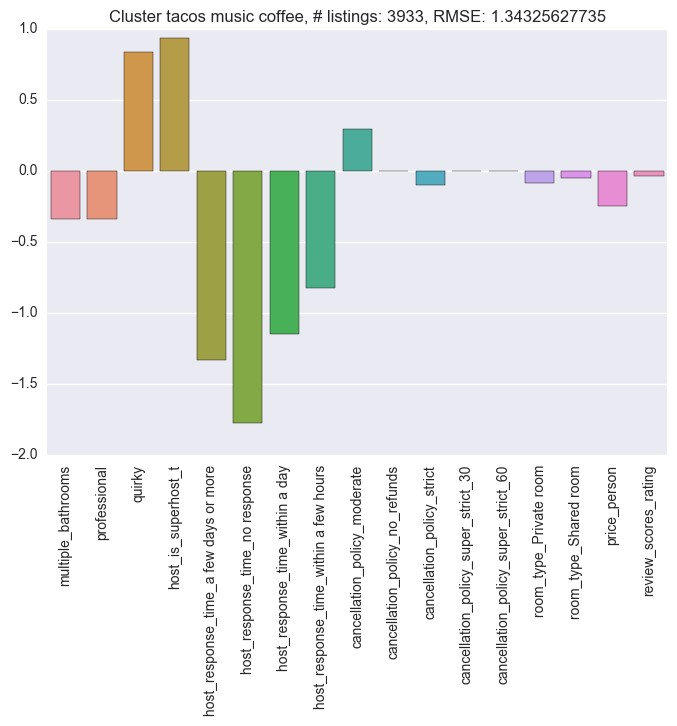

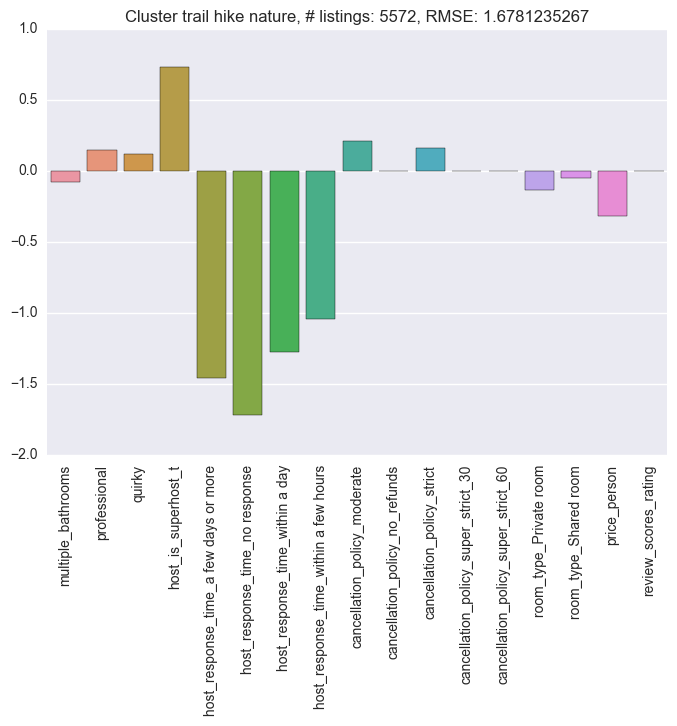

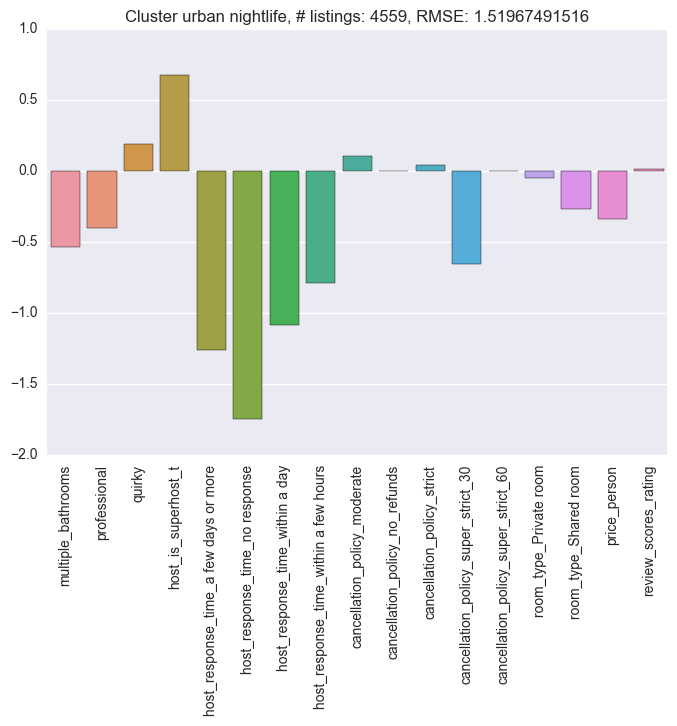

In [34]:
for cluster in clusters:
    plot_hyperlocals(cluster)

In [35]:
def plot_coefficients(dct, key):
    #clusters = range(0,16)
    coefficients = dct[key]    
    fig, ax = plt.subplots()
    fig = sns.barplot(clusters, coefficients)
    #ax.set_ybound(lower=0, upper=0.5)
    fig.axes.set_title(key)
    plt.xticks(rotation=90);

In [36]:
coef_values['cancellation_policy_moderate']

[0.2655253436753645,
 0.28314796486341715,
 0.3888456285133776,
 0.10104523601477922,
 0.09239101782602566,
 0.09670152662397888,
 0.2317897274927221,
 0.2426410085327173,
 0.546742589892153,
 0.06150256992044434,
 0.4664047471817807,
 0.14344069048201502,
 0.29245222968140355,
 0.2132092835599464,
 0.10739953524350265]

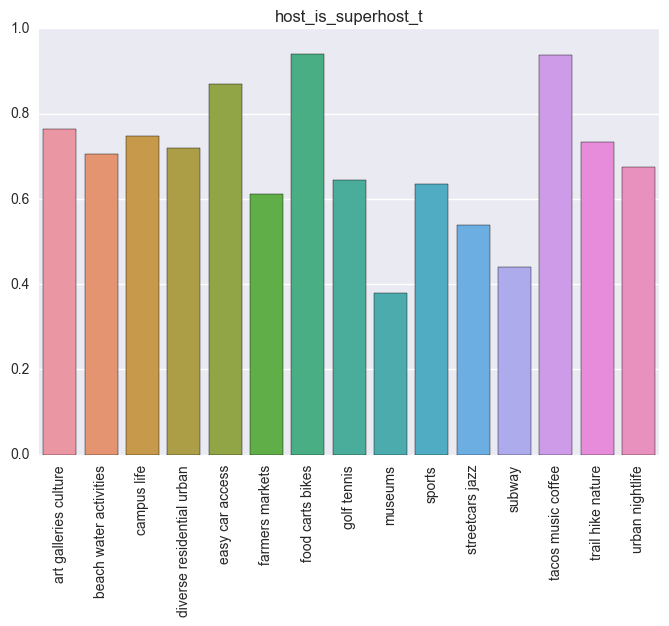

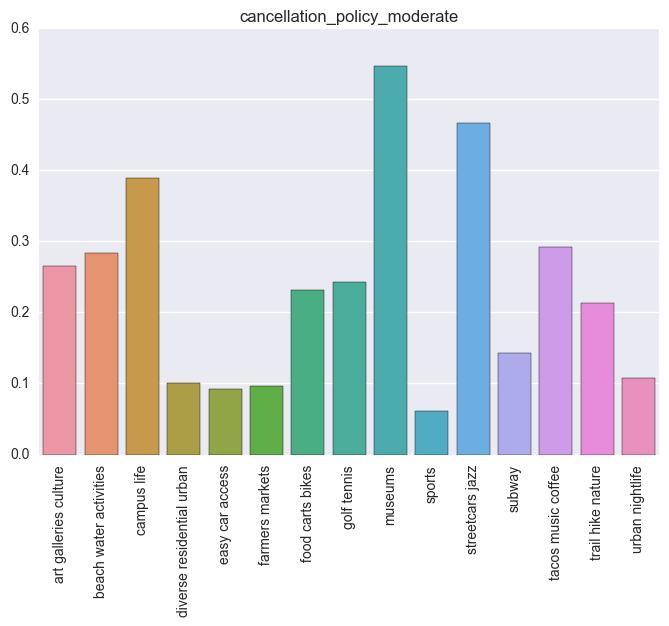

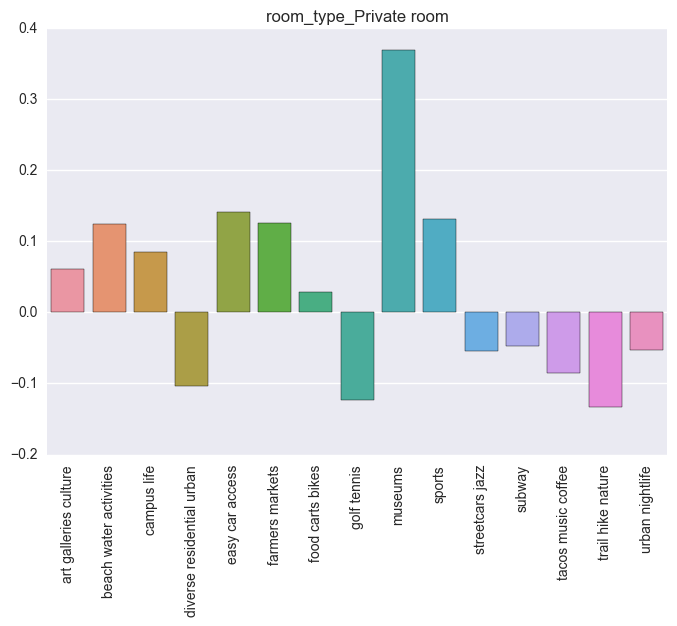

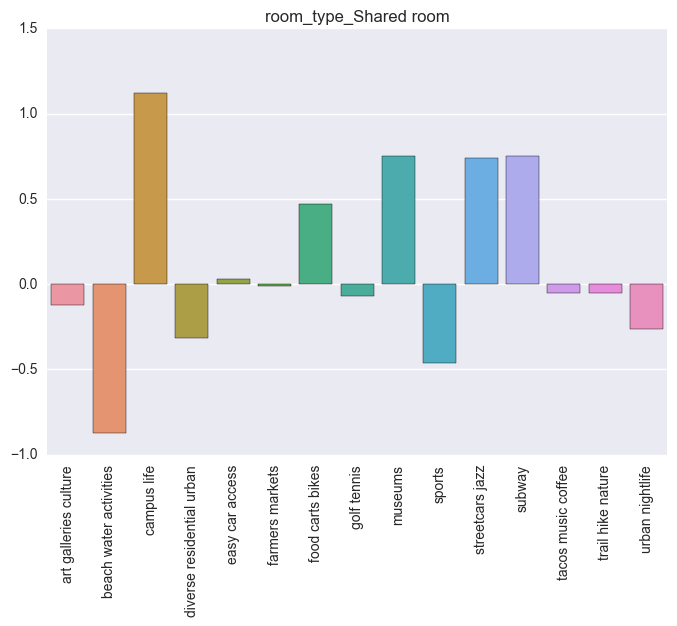

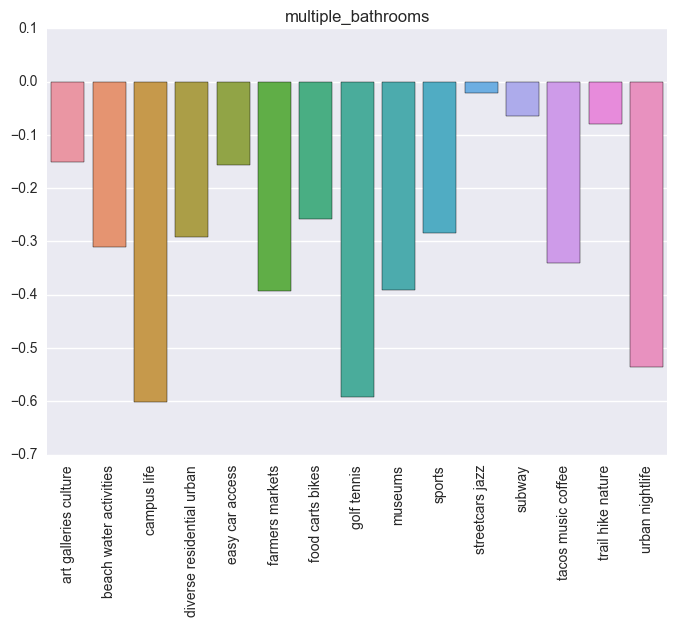

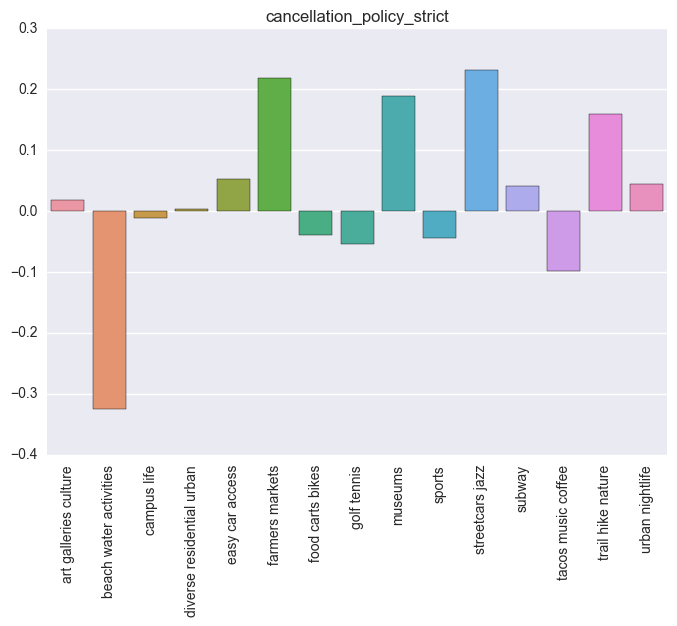

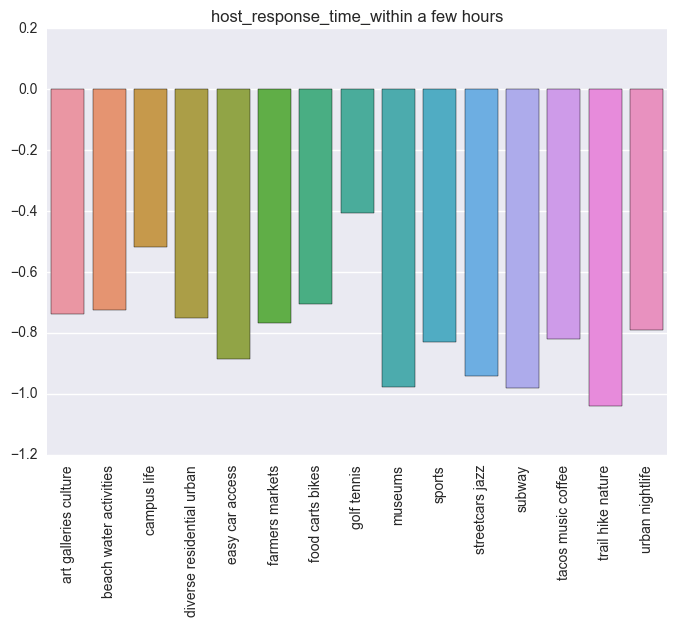

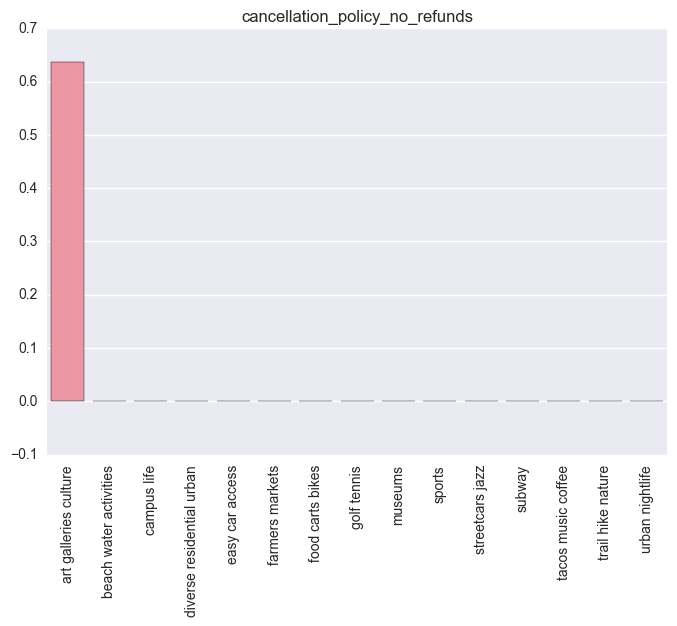

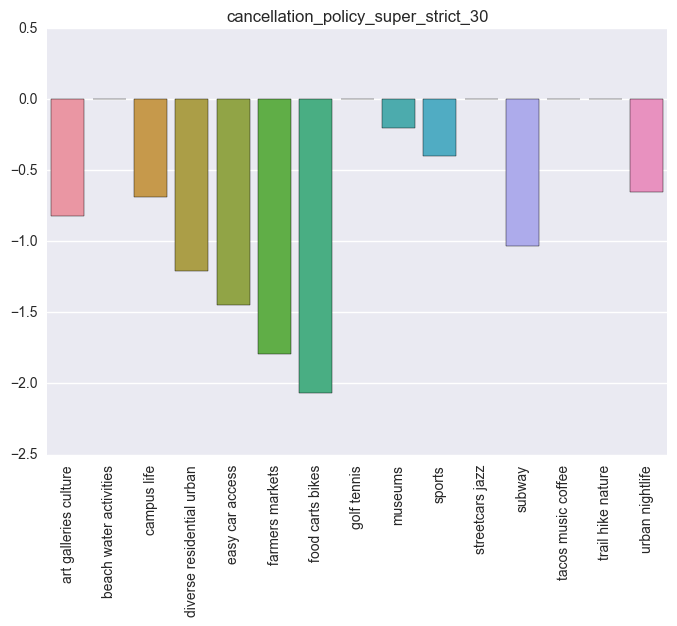

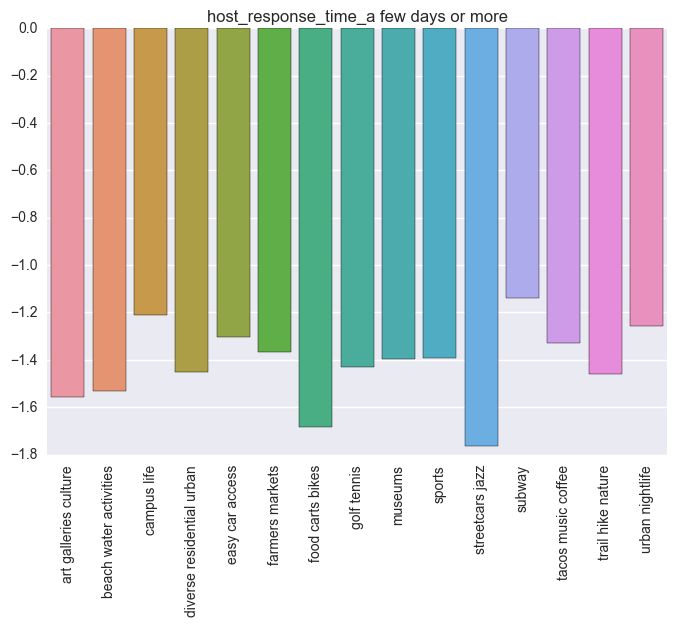

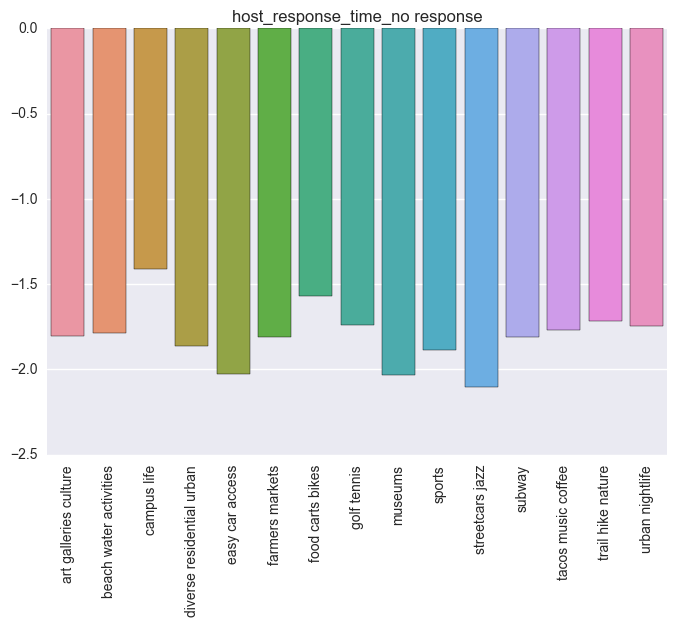

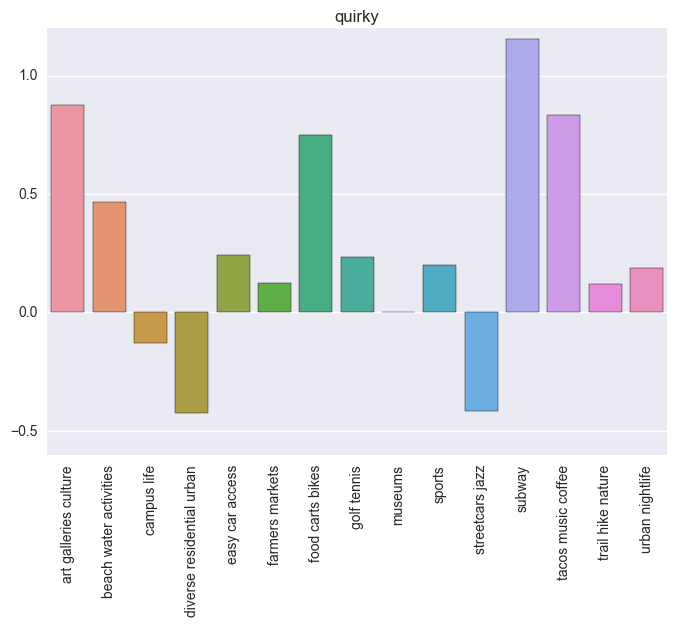

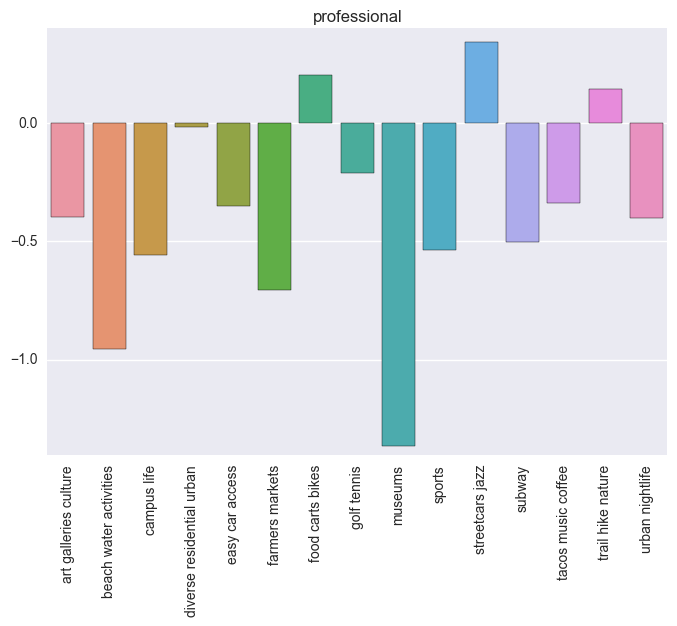

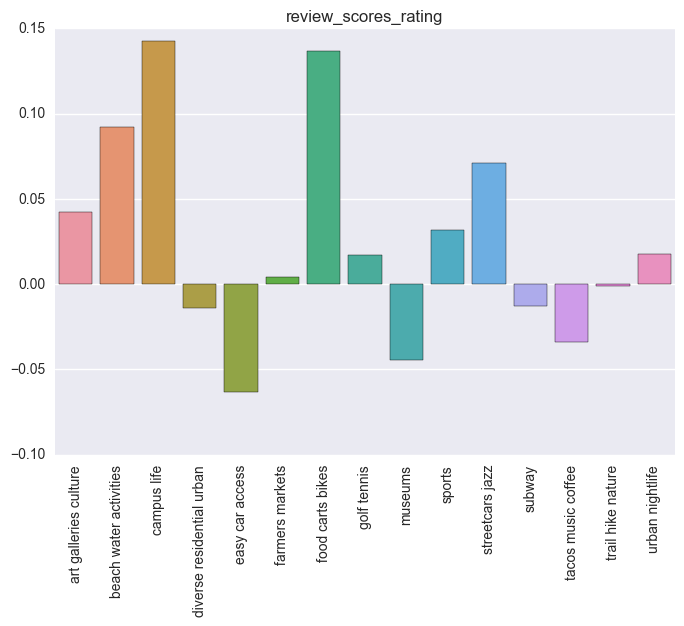

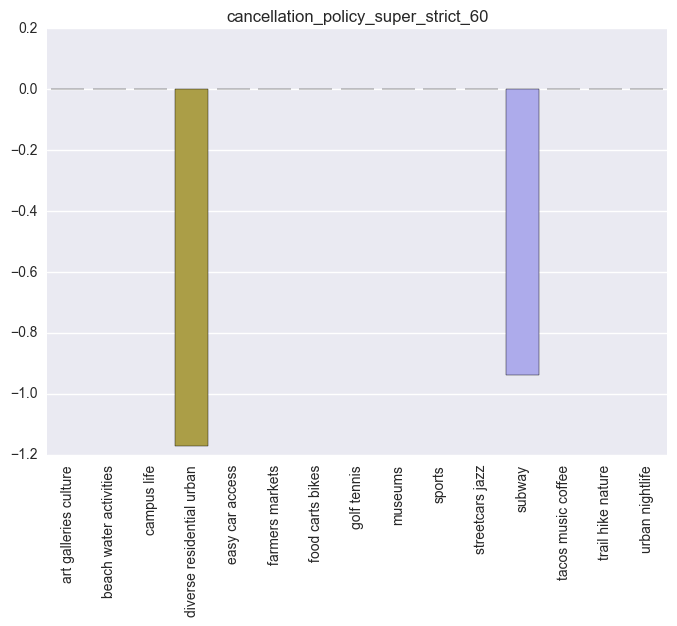

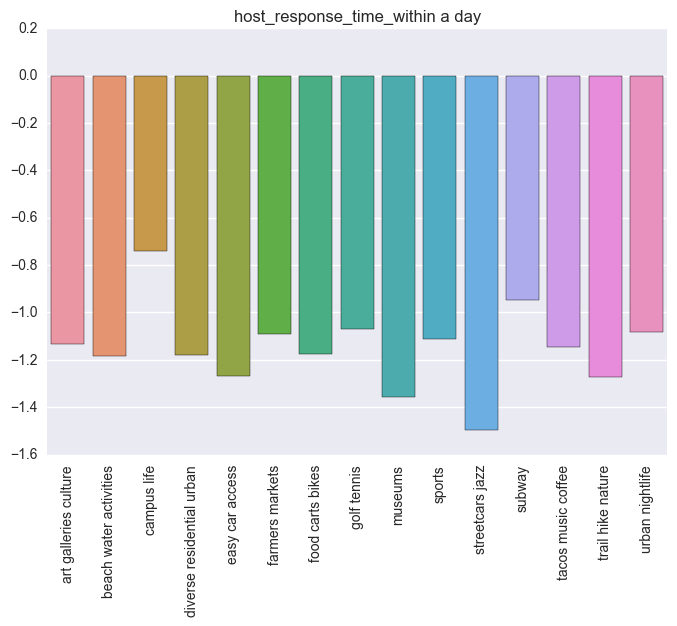

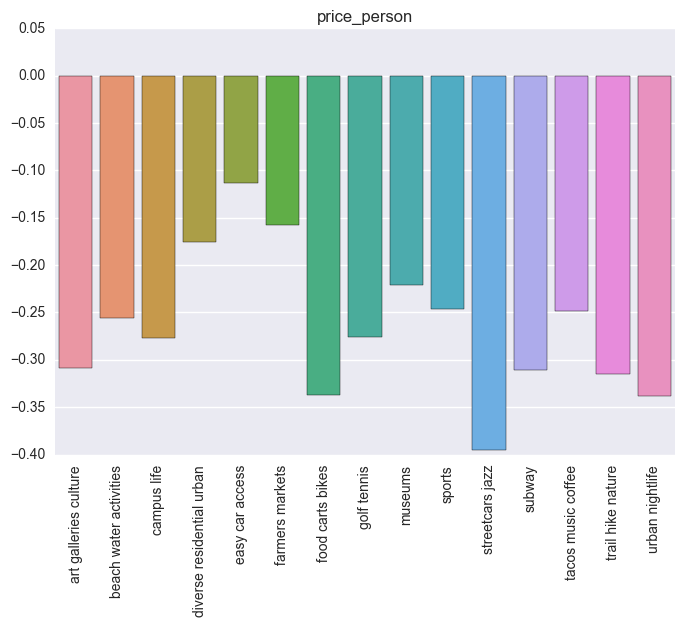

In [37]:
for coefficient in coef_values.keys():
    plot_coefficients(coef_values, coefficient)